In [1]:
import os
import numpy as nu
import pandas as ps

import seaborn as sb

import tensorflow as tnf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef as MTC
from sklearn.metrics import balanced_accuracy_score as BS
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
import tensorflow_addons as tnfa
import matplotlib.pyplot as mplt
import matplotlib.gridspec as gridspec
from distutils.dir_util import copy_tree, remove_tree
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDGN

In [2]:
classes = ["damage", "no_damage"]
path = "/kaggle/input/satellite-images-of-hurricane-damage/train_another"

file_path = [os.path.join(path, "damage/-93.55964_30.895018.jpeg"),os.path.join(path, "no_damage/-95.061275_29.831535.jpeg")]

In [3]:
h_model = ResNet50(input_shape=(224,224,3), include_top=True)
h_metrics = [tf.keras.metrics.CategoricalAccuracy(name='acc'),tnf.keras.metrics.AUC(name='auc'),tnfa.metrics.F1Score(num_classes=2)]
h_model.compile(optimizer='adam',loss=tnf.losses.CategoricalCrossentropy(),metrics=h_metrics)

h_model.summary()

102967424/102967424 [==============================] - 4s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [4]:
vector = model.get_layer("avg_pool").output
feature_extractor = tf.keras.Model(model.input, vector)

In [5]:
X_list = []
Y_list = []

for f in range(2):    
    folder_path = os.path.join(path, classes[f])
    for file in os.listdir(folder_path):    
        file_path = os.path.join(folder_path, file)
        
        # check file extension, skip file if not jpg
        if not(file.endswith(".jpeg")):
            continue
        
        # load image
        img = image.load_img(file_path, target_size=(224,224))
        # convert image to numpy array
        img_arr = image.img_to_array(img)
        # add 1 more dimension
        img_arr_b = np.expand_dims(img_arr, axis=0)
        # preprocess image
        input_img = preprocess_input(img_arr_b)
        # extract feature
        feature_vec = feature_extractor.predict(input_img)
    
        X_list.append(feature_vec.ravel())
        Y_list.append(f)

1/1 [==============================] - 0s 29ms/step


In [6]:
X = np.asarray(X_list, dtype=np.float32)
Y = np.asarray(Y_list, dtype=np.float32)

for s in range(100):
    X, Y = shuffle(X, Y)
    
print("Shape of feature matrix X")
print(X.shape)
print("\nShape of label matrix Y")
print(Y.shape)

class_types, counts = np.unique(Y, return_counts=True)

print("\nClass labels")
print(class_types)
print("\nClass counts")
print(counts)

Shape of feature matrix X
(10000, 2048)

Shape of label matrix Y
(10000,)

Class labels
[0. 1.]

Class counts
[5000 5000]


In [7]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2,
                                                    stratify=Y,
                                                    random_state=0)

print("Shape of train_X")
print(train_X.shape)
print("\nShape of test_X")
print(test_X.shape)

Shape of train_X
(8000, 2048)

Shape of test_X
(2000, 2048)


In [8]:
from sklearn import svm
svm_lin = svm.SVC(C=1.75, kernel="linear")
svm_lin.fit(train_X, train_Y)
y_pred = svm_lin.predict(test_X)
print(classification_report(test_Y, y_pred,
                            target_names=classes))
print(confusion_matrix(test_Y, y_pred))

              precision    recall  f1-score   support

      damage       0.88      0.91      0.89      1000
   no_damage       0.90      0.88      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

[[907  93]
 [123 877]]


In [9]:
import numpy as np
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('ACTUAL', fontsize=18)
    font = {'family' : 'serif',
        'weight' : 'bold'}
    plt.xlabel('PREDICTED',fontsize=12)# label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    font = {'family' : 'serif',
        'weight' : 'bold'}
    plt.show()

In [10]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 18}
import matplotlib.pyplot as plt
plt.rc('font', **font)
#plt.rcParams({'font.family':'serif', 'font.serif':'Times New Roman'})
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 12

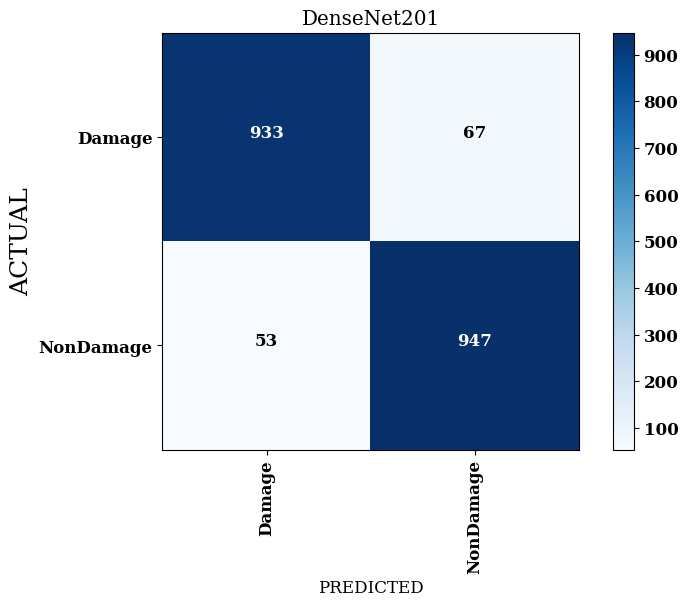

In [24]:
plot_confusion_matrix(cm           = np.array([[933,  67],
                                               [53, 947]]),

                      normalize    = False,
                      target_names = ["Damage", "NonDamage"],
                      title        = "1") 

In [12]:
n_encoder = OneHotEncoder(sparse=False)

# fit encoder to train_Y
n_encoder.fit(train_Y.reshape(-1,1))
# transform train_Y
e_train_Y = n_encoder.transform(train_Y.reshape(-1,1))
# transform test_Y
e_test_Y = n_encoder.transform(test_Y.reshape(-1,1))

In [13]:
def create_model():
    model = Sequential()
    model.add(Dense(1000, input_dim=2048, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(2, kernel_regularizer=l2(0.1), activation="linear"))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                 loss="categorical_hinge",metrics=METRICS)
    return model

epoch = 1000
model = create_model()
history = model.fit(train_X, e_train_Y,
                    validation_split = 0.15,
                    epochs=epoch, batch_size=64, verbose=1)

Epoch 1/1000
107/107 [==============================] - 3s 9ms/step - loss: 0.7459 - acc: 0.7987 - auc: 0.5011 - f1_score: 0.7987 - val_loss: 0.4787 - val_acc: 0.8583 - val_auc: 0.5000 - val_f1_score: 0.8576
Epoch 2/1000
107/107 [==============================] - 1s 6ms/step - loss: 0.4544 - acc: 0.8537 - auc: 0.5011 - f1_score: 0.8537 - val_loss: 0.4098 - val_acc: 0.8600 - val_auc: 0.5021 - val_f1_score: 0.8597
Epoch 3/1000
107/107 [==============================] - 1s 6ms/step - loss: 0.3911 - acc: 0.8728 - auc: 0.6014 - f1_score: 0.8728 - val_loss: 0.3753 - val_acc: 0.8683 - val_auc: 0.6794 - val_f1_score: 0.8683
Epoch 4/1000
107/107 [==============================] - 1s 6ms/step - loss: 0.3655 - acc: 0.8731 - auc: 0.8078 - f1_score: 0.8731 - val_loss: 0.3660 - val_acc: 0.8683 - val_auc: 0.8580 - val_f1_score: 0.8673
Epoch 5/1000
107/107 [==============================] - 1s 6ms/step - loss: 0.3334 - acc: 0.8782 - auc: 0.8944 - f1_score: 0.8782 - val_loss: 0.3347 - val_acc: 0.8767 -

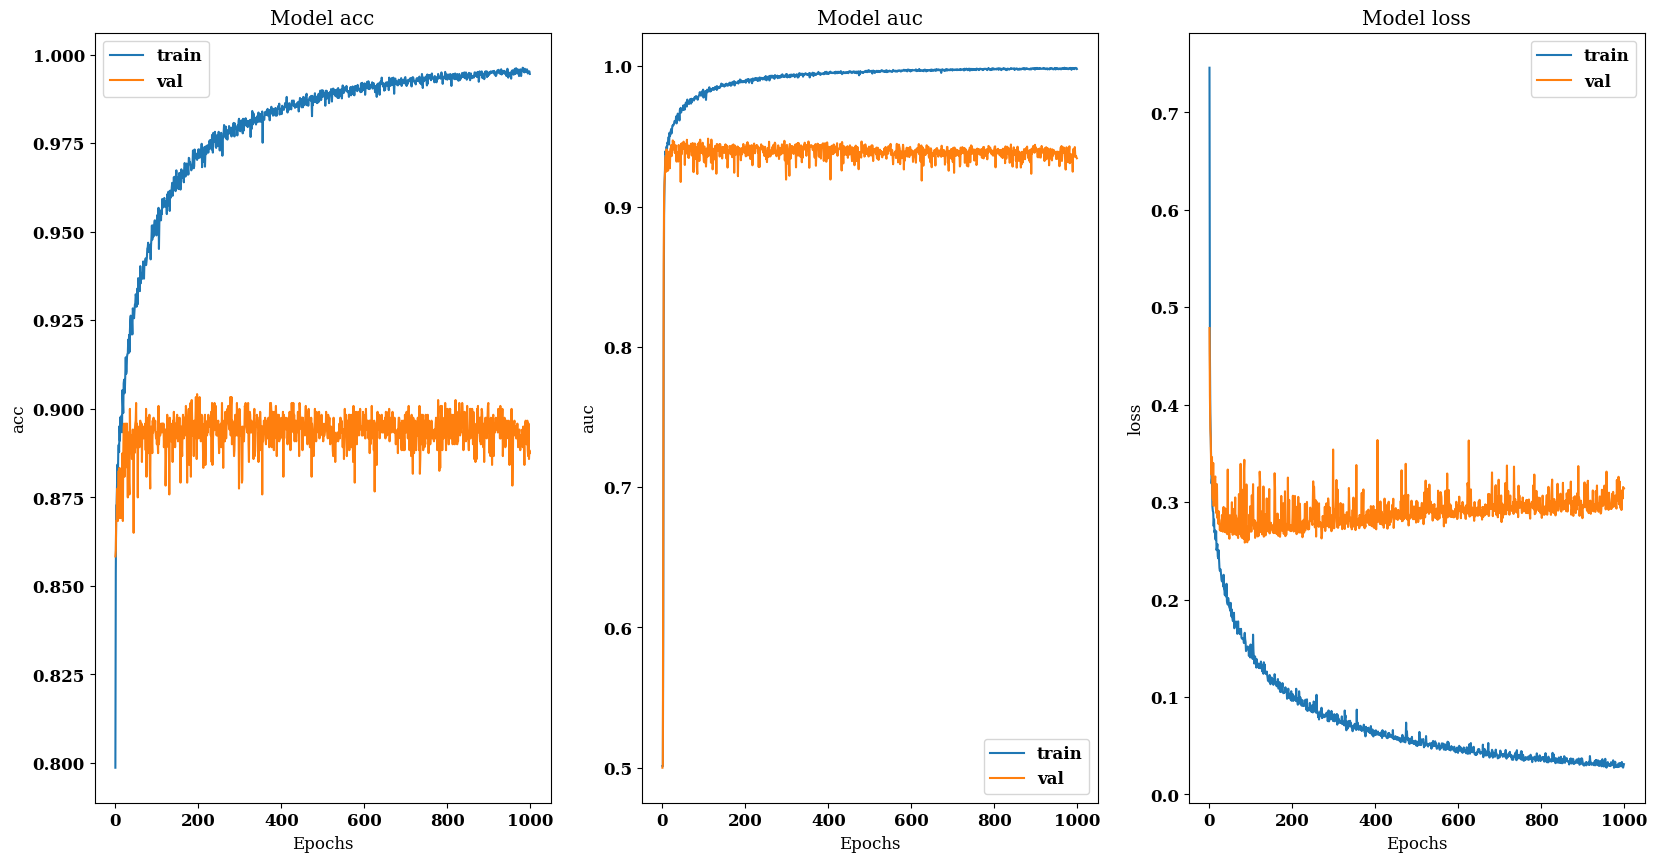

In [14]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (20, 10))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
    
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 12}
import matplotlib
matplotlib.rc('font', **font)
#plt.rcParams({'font.family':'serif', 'font.serif':'Times New Roman'})
plt.rcParams["font.family"] = "serif"

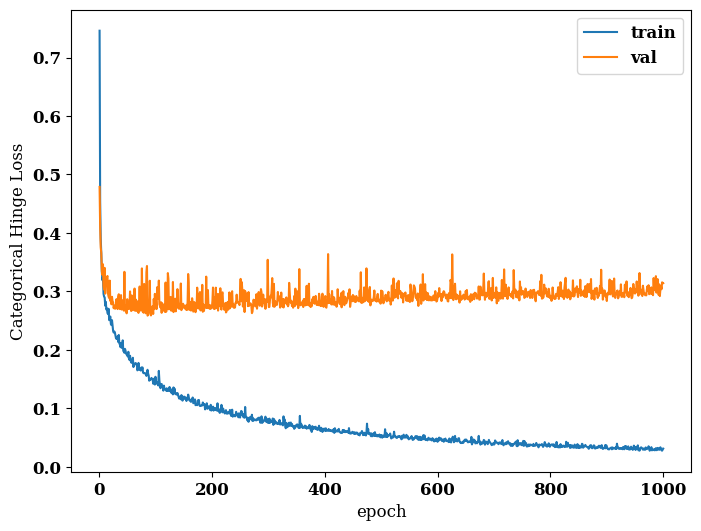

In [15]:
e = np.linspace(1, epoch, epoch)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
sea.lineplot(x = e, y = history.history["loss"],
             ax=axes, label="train");
sea.lineplot(x = e, y = history.history["val_loss"],
             ax=axes, label="val");
axes.set_ylabel("Categorical Hinge Loss")
axes.set_xlabel("epoch");

In [16]:
y_pred = np.argmax(model.predict(test_X), axis=-1);
print(classification_report(test_Y, y_pred,
                            target_names=classes))
print(confusion_matrix(test_Y, y_pred))

63/63 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

      damage       0.91      0.87      0.89      1000
   no_damage       0.87      0.92      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

[[867 133]
 [ 83 917]]


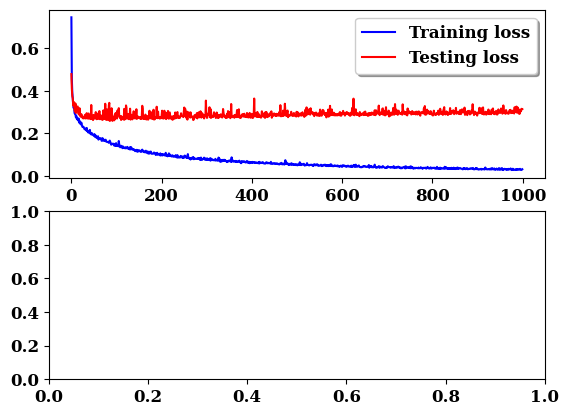

In [17]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Testing loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

plt.show()

In [18]:
import numpy as np
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('ACTUAL', fontsize=18)
    font = {'family' : 'serif',
        'weight' : 'bold'}
    plt.xlabel('PREDICTED',fontsize=12)# label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    font = {'family' : 'serif',
        'weight' : 'bold'}
    plt.show()

In [19]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 18}
import matplotlib.pyplot as plt
plt.rc('font', **font)
#plt.rcParams({'font.family':'serif', 'font.serif':'Times New Roman'})
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 12

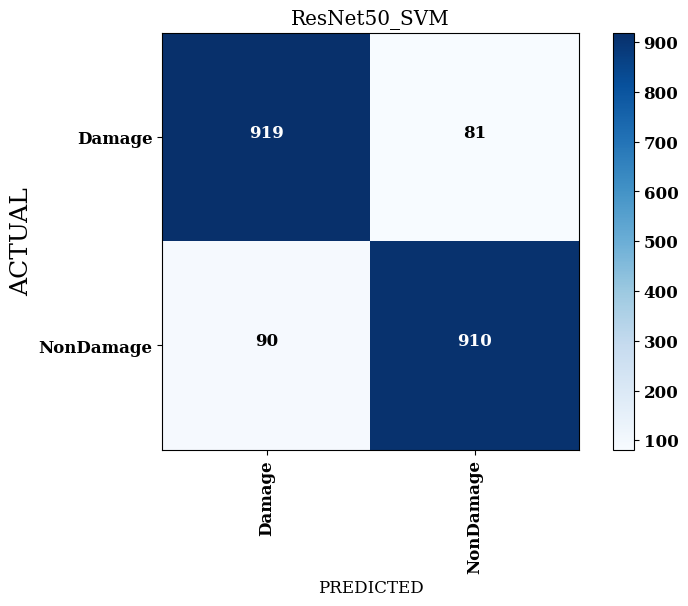

In [20]:
plot_confusion_matrix(cm           = np.array([[919,  81],
                                               [90, 910]]),

                      normalize    = False,
                      target_names = ["Damage", "NonDamage"],
                      title        = "ResNet50_SVM")